In [ ]:
 ## to access the google drive with the google account
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
from PIL import Image
import os
import torch
import torchvision
import cv2
import argparse
import numpy as np
import random
import skimage
import matplotlib.pyplot as plt
from torchvision.transforms import transforms as transforms
from skimage.color import rgb2gray
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage import io, segmentation
from skimage.io import imread
from skimage.util import img_as_ubyte
from skimage.util import img_as_float
from skimage.segmentation import mark_boundaries
from skimage.filters import sobel
from sklearn.cluster import KMeans
import torchvision.transforms.functional as F
from skimage.color import rgb2lab
import math


In [ ]:


# initialize the model
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True, progress=True, 
                                                           num_classes=91)
# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# load the modle on to the computation device and set to eval mode
model.to(device).eval()

# transform to convert the image to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# this will help us create a different color for each class
COLORS = np.random.uniform(0, 255, size=(1000, 3))

def get_outputs(outputs):
    scores = list(outputs[0]['scores'].detach().cpu().numpy())

    max_value = max(scores)
    thresholded_preds_inidices = scores.index(max_value)

    # get the masks
    ## here we only pick one
    masks = (outputs[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    # discard masks for objects which are below threshold
    masks = masks[:1]
    # get the bounding boxes, in (x1, y1), (x2, y2) format
    boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]  for i in outputs[0]['boxes'].detach().cpu()]
    # discard bounding boxes below threshold value
    boxes = boxes[:1]

    return masks, boxes

def draw_segmentation_map(image, masks, boxes):
    alpha = 1 
    beta = 0.6 # transparency for the segmentation map
    gamma = 0 # scalar added to each sum
    for i in range(len(masks)):
        red_map = np.zeros_like(masks[i]).astype(np.uint8)
        green_map = np.zeros_like(masks[i]).astype(np.uint8)
        blue_map = np.zeros_like(masks[i]).astype(np.uint8)
        # apply a randon color mask to each object
        color = COLORS[random.randrange(0, len(COLORS))]
        red_map[masks[i] == 1], green_map[masks[i] == 1], blue_map[masks[i] == 1]  = color
        # combine all the masks into a single image
        segmentation_map = np.stack([red_map, green_map, blue_map], axis=2)
        #convert the original PIL image into NumPy format
        image = np.array(image)
        # apply mask on the image
        cv2.addWeighted(image, alpha, segmentation_map, beta, gamma, image)
        # draw the bounding boxes around the objects
        cv2.rectangle(image, boxes[i][0], boxes[i][1], color=color, 
                      thickness=5)

    
    return image


Original Image (Left) & Superpixel with the most Red pixels (Right):


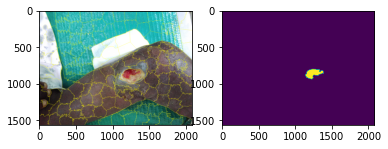

In [11]:
#refined 1
images = 'CD00000765_20210614114023_0002_20210614114201_20210614_114559.jpg'

folder = images[0:10]
image_path = '/content/drive/MyDrive/Skin_Disease/Skin_Images/' + folder + '/' + images + ''

sk_image = io.imread(image_path)

segment_slic = slic(sk_image, n_segments=150, compactness=10, sigma=1, start_label=0)

base_distance = 256
#distance that cannot be reached (too far) to set a baseline

red = 0

for index in np.unique(segment_slic):

  superpixel = (segment_slic == index)
  #make sure that the segment equals the current index and set variable superpixel equal to that

  average_superpixel_color = np.average(rgb2lab(sk_image[superpixel]),axis=0)
  #average color of each superpixel

  lab_superpixel_color = rgb2lab([[average_superpixel_color]])
  #turn the average color from rgb2lab so it can be compared mathematically

  avg_superpixel_red = np.clip(lab_superpixel_color,0,255,out=lab_superpixel_color)

  euclidean_distance = math.dist(avg_superpixel_red[0][0], [255,0,0])
  #comparing euclidean distance from color red to the average red color of each super pixel
  
  if euclidean_distance < base_distance:
    base_distance = euclidean_distance
    red = superpixel
    #compare each distance from to see which super pixel has the smallest distance


print('Original Image (Left) & Superpixel with the most Red pixels (Right):')
plt.subplot(1, 2, 1)
plt.imshow(mark_boundaries(sk_image,segment_slic))

plt.subplot(1, 2, 2)
plt.imshow(red)


plt.show()
